## These models predict deltaI and deltaR using training data created with the MATLAB code ES_AG_Spec_v1 and a scale factor of 0.8993 


In [1]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import *

from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler  



## This function will plot the true vs. predicted with various line fits
def plotSummary(true, predicted, name):
    #from pylab import *
    #import numpy as np
    #import matplotlib.pyplot as plt
    
    figure()
    plt.scatter(true,predicted, alpha = 0.2)
    
    plt.title(name)
    plt.xlabel('True')
    plt.ylabel('Predicted')

    xmin, xmax = plt.xlim()
    plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

    fit_temp = np.polyfit(true, predicted,1)
    xp = np.linspace(xmin, xmax, 100)
    p = np.poly1d(fit_temp)
    plt.plot(xp, p(xp), '-', color = 'black')
    
    print(' ')
    print('RMSE on test data:', np.sqrt(mean_squared_error(true, predicted)), 'for ', name)
    print('R^2 Score on test data:', r2_score(true, predicted), 'for', name)

    
    return

def myResiduals(testY, predictY):
    ## residuals 1
    i = 0 # resetting i
    iterations = len(testY) # gets number of dots/points
    residual_sum = 0 # initializes sum of residuals
    for i in range (0,iterations): # for every dot/point
       ys = testY # get ys of testing data
       ys = ys.values # take out indexing, data types, names
       y = ys[i]
       predict_ys = predictY.values # get ys of all dots/points
       predict_y = predict_ys[i] # get the y value of the dot/point at specfic x value i
       diff = y - predict_y # find the difference in height
       diff = abs(diff) # take the absolute value
       residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals
    residual_average = residual_sum/iterations # find the average of the residuals
    print('The average residual for predict:', round(residual_average,4)) # display average of residuals

    minY = min(ys) # find the minimum y value for testing data
    maxY = max(ys) # find the max y value for testing data
    minpredict = min(predictY) # find the min y value for the prediction data
    maxpredict = max(predictY) # find the max y value for the prediction data
    #print('minY', minY, 'maxY', maxY)
    #print('minpredict', minpredict, 'maxpredict', maxpredict)
    rangeY = minY + maxY # find the range of the testing data
    rangepredict = minpredict - maxpredict # find the range of the predictions
    #print('rangeY', rangeY)
    #print('rangepredict', rangepredict)
    residual_percent_rangepredict = (residual_average/abs(rangepredict))*100 # calculate what percent the residual is of the range
    print('Residual is this percent of predict range', round(residual_percent_rangepredict,3), '%')
    
    return

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [2]:
# Creating Column Names 

energy = (pd.read_csv('Training_Data/Graphene/GrapheneTrainingData180722_bias.csv', header=None)*1000).round().astype(int)
energy_names = ['E_%i_mV' % item for item in list(energy.T[0])]
# subset = 5 This would be used if we wanted a different number of spec points spaced differently. 
# energy_names2 = energy_names[50:] # This would be used if we wanted to exclude the specs of the first peak -400 to -350 

# col_names1 = ['deltaI', 'deltaR', 'scale factor'] + energy_names

col_names1 = ['deltaI', 'deltaR'] + energy_names # this would be used if we didn't want the scale factor 

In [3]:
# Loading Training Data 
# Spec Points
data1 = pd.read_csv('Training_Data/Graphene/ES_AG_Spec_data_180806_sf_0.91.csv', header = None)
data1.drop(data1.iloc[:, 3:454], inplace=True, axis=1)
data1.columns = col_names1
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,-0.29103,0.85577,0.51349,0.54197,0.54516,0.54861,0.55218,0.55566,0.55938,0.56284,...,0.79013,0.79269,0.79488,0.79681,0.79829,0.79954,0.80056,0.80143,0.80226,0.80296
1,-0.14798,0.67080,0.56455,0.59139,0.59598,0.60074,0.60551,0.61012,0.61488,0.61927,...,0.81727,0.81931,0.82105,0.82258,0.82372,0.82469,0.82548,0.82614,0.82678,0.82732
2,-1.37130,0.52359,0.34366,0.38100,0.37412,0.36791,0.36245,0.35716,0.35257,0.34820,...,0.65931,0.66456,0.66917,0.67324,0.67647,0.67912,0.68120,0.68283,0.68415,0.68497
3,-0.13607,0.29882,0.69524,0.71425,0.72339,0.73226,0.74068,0.74889,0.75690,0.76431,...,0.90640,0.90734,0.90818,0.90886,0.90935,0.90976,0.91011,0.91038,0.91067,0.91095
4,-0.57749,0.70397,0.43711,0.46366,0.46754,0.47174,0.47622,0.48070,0.48552,0.49018,...,0.78680,0.78962,0.79204,0.79412,0.79572,0.79706,0.79819,0.79916,0.80015,0.80107


In [4]:
# Manipulating Training Data 
# col_names1a = ['deltaI', 'deltaR'] + energy_names[50:] # this would be used if we wanted to exclude the first peak 

#X1 = data1.drop(['deltaI', 'deltaR', 'scale factor'], axis = 1)
#Y1 = data1[['deltaI', 'deltaR', 'scale factor']]
X1 = data1.drop(['deltaI', 'deltaR'], axis = 1)
Y1 = data1[['deltaI', 'deltaR']]

In [5]:
# Splitting Training and Testing Data 
ts1 = 0.3
rs1 = 42

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs1)

In [6]:
# Checking Spec points Data 
X1.head()

,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,E_-384_mV,E_-382_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,0.51349,0.54197,0.54516,0.54861,0.55218,0.55566,0.55938,0.56284,0.56673,0.57048,...,0.79013,0.79269,0.79488,0.79681,0.79829,0.79954,0.80056,0.80143,0.80226,0.80296
1,0.56455,0.59139,0.59598,0.60074,0.60551,0.61012,0.61488,0.61927,0.62398,0.62849,...,0.81727,0.81931,0.82105,0.82258,0.82372,0.82469,0.82548,0.82614,0.82678,0.82732
2,0.34366,0.38100,0.37412,0.36791,0.36245,0.35716,0.35257,0.34820,0.34459,0.34121,...,0.65931,0.66456,0.66917,0.67324,0.67647,0.67912,0.68120,0.68283,0.68415,0.68497
3,0.69524,0.71425,0.72339,0.73226,0.74068,0.74889,0.75690,0.76431,0.77188,0.77917,...,0.90640,0.90734,0.90818,0.90886,0.90935,0.90976,0.91011,0.91038,0.91067,0.91095
4,0.43711,0.46366,0.46754,0.47174,0.47622,0.48070,0.48552,0.49018,0.49540,0.50062,...,0.78680,0.78962,0.79204,0.79412,0.79572,0.79706,0.79819,0.79916,0.80015,0.80107


In [7]:
# Checking Spec Points Data 
data1.head()

,deltaI,deltaR,E_-400_mV,E_-398_mV,E_-396_mV,E_-394_mV,E_-392_mV,E_-390_mV,E_-388_mV,E_-386_mV,...,E_482_mV,E_484_mV,E_486_mV,E_488_mV,E_490_mV,E_492_mV,E_494_mV,E_496_mV,E_498_mV,E_500_mV
0,-0.29103,0.85577,0.51349,0.54197,0.54516,0.54861,0.55218,0.55566,0.55938,0.56284,...,0.79013,0.79269,0.79488,0.79681,0.79829,0.79954,0.80056,0.80143,0.80226,0.80296
1,-0.14798,0.67080,0.56455,0.59139,0.59598,0.60074,0.60551,0.61012,0.61488,0.61927,...,0.81727,0.81931,0.82105,0.82258,0.82372,0.82469,0.82548,0.82614,0.82678,0.82732
2,-1.37130,0.52359,0.34366,0.38100,0.37412,0.36791,0.36245,0.35716,0.35257,0.34820,...,0.65931,0.66456,0.66917,0.67324,0.67647,0.67912,0.68120,0.68283,0.68415,0.68497
3,-0.13607,0.29882,0.69524,0.71425,0.72339,0.73226,0.74068,0.74889,0.75690,0.76431,...,0.90640,0.90734,0.90818,0.90886,0.90935,0.90976,0.91011,0.91038,0.91067,0.91095
4,-0.57749,0.70397,0.43711,0.46366,0.46754,0.47174,0.47622,0.48070,0.48552,0.49018,...,0.78680,0.78962,0.79204,0.79412,0.79572,0.79706,0.79819,0.79916,0.80015,0.80107


# Using the Best Models on the Hexagon Data 

## Decision Tree

### spec points

 
RMSE on test data: 0.02450519357996358 for  deltaI Depth 60
R^2 Score on test data: 0.9969867237727437 for deltaI Depth 60
 
RMSE on test data: 0.024348143824494142 for  deltaR Depth 60
R^2 Score on test data: 0.9933453337819593 for deltaR Depth 60


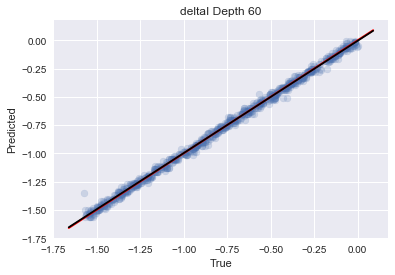

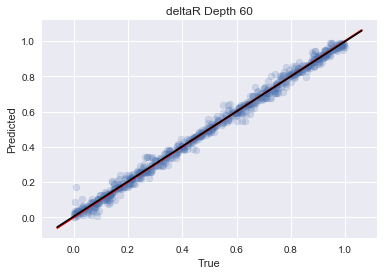

In [8]:
#Initialize the model
rs = 42
regr_DT_sp = DecisionTreeRegressor(max_depth=60, min_samples_leaf = 2, random_state = rs)

#Fit the model
regr_DT_sp = regr_DT_sp.fit(X1_train, Y1_train)

#print(data1[data1['Regr - DT']>0.001]) # feature importances 

#Use model to predict
predictions_DT_sp = regr_DT_sp.predict(X1_test)

#Plot results
plotSummary(Y1_test['deltaI'], predictions_DT_sp[:,0], 'deltaI Depth 60')
#myResiduals(Y_test['deltaI'], y_3[:,0])
plotSummary(Y1_test['deltaR'], predictions_DT_sp[:,1], 'deltaR Depth 60')
#myResiduals(Y_test['deltaR'], y_3[:,1])
#plotSummary(Y1_test['scale factor'], predictions_DT_sp[:,2], 'scale factor Depth 60')
#myResiduals(Y_test['scale factor'], y_3[:,2])

In [9]:
# spec info decision tree feature importances 
FI_sp_DT = pd.DataFrame(regr_DT_sp.feature_importances_.T, columns = ['Spec - DT'])
FI_sp_DT.index = X1_train.columns

#print(FI_sp_DT[FI_sp_DT['Spec - DT']>0.001])
features_sp_DT = (FI_sp_DT[FI_sp_DT['Spec - DT']>0.006])
features_sp_DT_sorted = features_sp_DT.sort_values('Spec - DT', ascending = False)
features_sp_DT_sorted

,Spec - DT
E_458_mV,0.532878
E_120_mV,0.107920
E_338_mV,0.104850
E_244_mV,0.038953
E_-394_mV,0.037416
E_362_mV,0.031228
E_2_mV,0.026583
E_246_mV,0.010332
E_308_mV,0.009630
E_-34_mV,0.008344


## Random Forest

### spec points

 
RMSE on test data: 0.008248020751307239 for  deltaI RF spec
R^2 Score on test data: 0.9996586325091456 for deltaI RF spec
 
RMSE on test data: 0.008924296247208344 for  deltaR RF spec
R^2 Score on test data: 0.9991059897105011 for deltaR RF spec


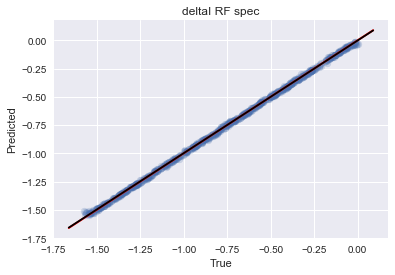

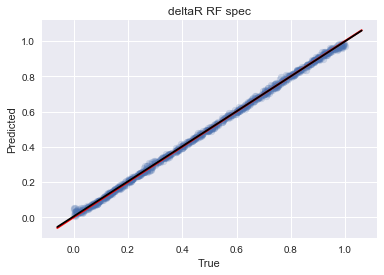

In [10]:
rs = 42
regr_RF_sp = RandomForestRegressor(max_depth = 40, n_estimators = 30, random_state=rs)

model_RF_sp = regr_RF_sp.fit(X1_train, Y1_train)

predictions_RF_sp = model_RF_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_RF_sp[:,0], 'deltaI RF spec')
plotSummary(Y1_test['deltaR'], predictions_RF_sp[:,1], 'deltaR RF spec')
#plotSummary(Y1_test['scale factor'], predictions_RF_sp[:,2], 'scale factor RF spec')

In [11]:
# spec info random forest feature importances 
FI_sp_RF = pd.DataFrame(regr_RF_sp.feature_importances_.T, columns = ['Spec - RF'])
FI_sp_RF.index = X1_train.columns

#print(FI_sp_RF[FI_sp_RF['Spec - RF']>0.001])
features_sp_RF = (FI_sp_RF[FI_sp_RF['Spec - RF']>0.006])
features_sp_RF_sorted = features_sp_RF.sort_values('Spec - RF', ascending = False)
features_sp_RF_sorted

,Spec - RF
E_454_mV,0.176913
E_458_mV,0.090080
E_460_mV,0.089218
E_-342_mV,0.054592
E_462_mV,0.037001
E_456_mV,0.035817
E_322_mV,0.027673
E_116_mV,0.026148
E_118_mV,0.024879
E_-340_mV,0.018822


## Independent Random Forests

### spec points


Score - Random Forest: 0.9994900720908516 for deltaR IRF
 
RMSE on test data: 0.006739956769982031 for  deltaR 10
R^2 Score on test data: 0.9994900720908516 for deltaR 10
 
RMSE on test data: 0.004633598884892787 for  deltaI 10
R^2 Score on test data: 0.9998922643238969 for deltaI 10


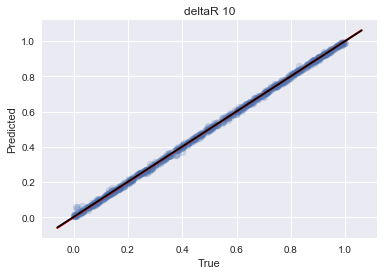

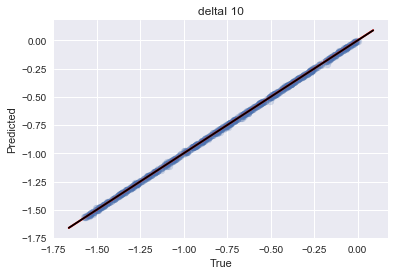

In [12]:
#Trying Independent Random Forest

rs = 42
md = 30
n = 30

regr_RF2_dr_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
regr_RF2_di_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)
#regr_RF2_sf_sp = RandomForestRegressor(max_depth = md, n_estimators = n, random_state = rs)

model_RF2_dr_sp = regr_RF2_dr_sp.fit(X1_train, Y1_train['deltaR'])
model_RF2_di_sp = regr_RF2_di_sp.fit(X1_train, Y1_train['deltaI'])
#model_RF2_sf_sp = regr_RF2_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_RF2_dr_sp = model_RF2_dr_sp.predict(X1_test)
predictions_RF2_di_sp = model_RF2_di_sp.predict(X1_test)
#predictions_RF2_sf_sp = model_RF2_sf_sp.predict(X1_test)

#importance_RF_10 = pd.Series(model_RF2.feature_importances_, index = X_train.columns)

print('')
print('Score - Random Forest:' , model_RF2_dr_sp.score(X1_test, Y1_test['deltaR']), 'for deltaR IRF')

plotSummary(Y1_test['deltaR'], predictions_RF2_dr_sp, 'deltaR 10')
plotSummary(Y1_test['deltaI'], predictions_RF2_di_sp, 'deltaI 10')
#plotSummary(Y1_test['scale factor'], predictions_RF2_sf_sp, 'scale factor IRF')

In [13]:
# spec info independent random forest feature importances delta R  
FI_sp_RF2_dr = pd.DataFrame(model_RF2_dr_sp.feature_importances_.T, columns = ['Spec - RF2_dr'])
FI_sp_RF2_dr.index = X1_train.columns

# print(FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.001])
features_sp_RF2_dr = (FI_sp_RF2_dr[FI_sp_RF2_dr['Spec - RF2_dr']>0.006])
features_sp_RF2_dr_sorted = features_sp_RF2_dr.sort_values('Spec - RF2_dr', ascending = False)

# spec info independent random forest feature importances delta I  
FI_sp_RF2_di = pd.DataFrame(model_RF2_di_sp.feature_importances_.T, columns = ['Spec - RF2_di'])
FI_sp_RF2_di.index = X1_train.columns

# print(FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.001])
features_sp_RF2_di = (FI_sp_RF2_di[FI_sp_RF2_di['Spec - RF2_di']>0.006])
features_sp_RF2_di_sorted = features_sp_RF2_di.sort_values('Spec - RF2_di', ascending = False)

# spec info independent random forest feature importances scale factor 
#FI_sp_RF2_sf = pd.DataFrame(model_RF2_sf_sp.feature_importances_.T, columns = ['Spec - RF2_sf'])
#FI_sp_RF2_sf.index = X1_train.columns

# print(FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.001])
#features_sp_RF2_sf = (FI_sp_RF2_sf[FI_sp_RF2_sf['Spec - RF2_sf']>0.006])
#features_sp_RF2_sf_sorted = features_sp_RF2_sf.sort_values('Spec - RF2_sf', ascending = False)
#features_sp_RF2_sf_sorted

## AdaBoost Random Forest

### spec points

 
RMSE on test data: 0.005454892265784994 for  AdaBoost Delta I SP
R^2 Score on test data: 0.9998506878924877 for AdaBoost Delta I SP
 
RMSE on test data: 0.007552239308207991 for  AdaBoost Delta R SP
R^2 Score on test data: 0.9993597552199854 for AdaBoost Delta R SP
Delta I AdaBoost Score: 0.9998506878924875
Delta R AdaBoost Score: 0.9993597552199854


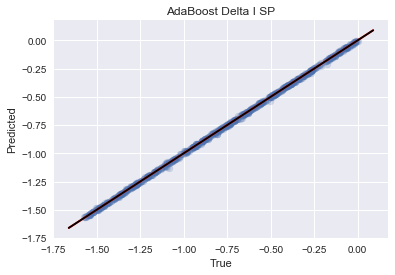

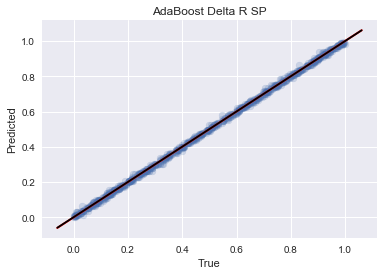

In [14]:
#Using AdaBoost Regression

from sklearn.ensemble import AdaBoostRegressor

rng = 42
md = 30
nest2 = 15

regr_AB_di_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md), n_estimators=nest2, random_state=rng)
regr_AB_dr_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)
#regr_AB_sf_sp = AdaBoostRegressor(DecisionTreeRegressor(max_depth = md),n_estimators=nest2, random_state=rng)

model_AB_di_sp = regr_AB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_AB_dr_sp = regr_AB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_AB_sf_sp = regr_AB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_AB_di_sp = model_AB_di_sp.predict(X1_test)
predictions_AB_dr_sp = model_AB_dr_sp.predict(X1_test)
#predictions_AB_sf_sp = model_AB_sf_sp.predict(X1_test)


plotSummary(Y1_test['deltaI'], predictions_AB_di_sp, 'AdaBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_AB_dr_sp, 'AdaBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_AB_sf_sp, 'AdaBoost Scale Factor SP')

print('Delta I AdaBoost Score:', model_AB_di_sp.score(X1_test, Y1_test['deltaI']))
print('Delta R AdaBoost Score:', model_AB_dr_sp.score(X1_test, Y1_test['deltaR']))
#print('Scale Factor AdaBoost Score:', model_AB_sf_sp.score(X1_test, Y1_test['scale factor']))


In [15]:
# spec info adaboost random forest feature importances delta R  
FI_sp_AB_dr = pd.DataFrame(model_AB_dr_sp.feature_importances_.T, columns = ['Spec - AB_dr'])
FI_sp_AB_dr.index = X1_train.columns

# print(FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.001])
features_sp_AB_dr = (FI_sp_AB_dr[FI_sp_AB_dr['Spec - AB_dr']>0.006])
features_sp_AB_dr_sorted = features_sp_AB_dr.sort_values('Spec - AB_dr', ascending = False)

# spec info adaboost random forest feature importances delta I  
FI_sp_AB_di = pd.DataFrame(model_AB_di_sp.feature_importances_.T, columns = ['Spec - AB_di'])
FI_sp_AB_di.index = X1_train.columns

# print(FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.001])
features_sp_AB_di = (FI_sp_AB_di[FI_sp_AB_di['Spec - AB_di']>0.006])
features_sp_AB_di_sorted = features_sp_AB_di.sort_values('Spec - AB_di', ascending = False)

# spec info adaboost random forest feature importances scale factor 
#FI_sp_AB_sf = pd.DataFrame(model_AB_sf_sp.feature_importances_.T, columns = ['Spec - AB_sf'])
#FI_sp_AB_sf.index = X1_train.columns

# print(FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.001])
#features_sp_AB_sf = (FI_sp_AB_sf[FI_sp_AB_sf['Spec - AB_sf']>0.006])
#features_sp_AB_sf_sorted = features_sp_AB_sf.sort_values('Spec - AB_sf', ascending = False)
#features_sp_AB_sf_sorted

## Gradient Boosting Random Forest

### spec points

 
RMSE on test data: 0.02026977016227135 for  GradientBoost Delta I SP
R^2 Score on test data: 0.9979383244587869 for GradientBoost Delta I SP
 
RMSE on test data: 0.017824992937126204 for  GradientBoost Delta R SP
R^2 Score on test data: 0.9964334091329059 for GradientBoost Delta R SP


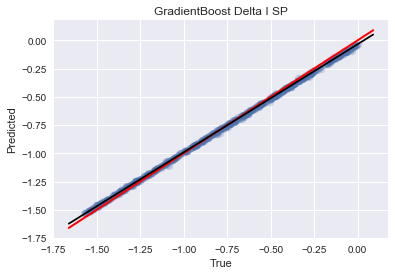

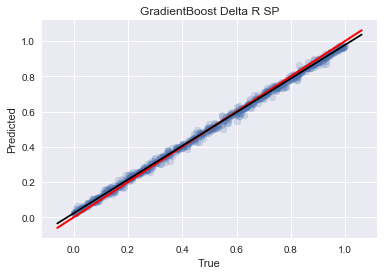

In [16]:
# Using Gradient Boosting Regression

from sklearn.ensemble import GradientBoostingRegressor

rng = 42

md = 50
nest2 = 30

regr_GB_di_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
regr_GB_dr_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)
#regr_GB_sf_sp = GradientBoostingRegressor(max_depth = md, n_estimators=nest2, random_state=rng)

model_GB_di_sp = regr_GB_di_sp.fit(X1_train, Y1_train['deltaI'])
model_GB_dr_sp = regr_GB_dr_sp.fit(X1_train, Y1_train['deltaR'])
#model_GB_sf_sp = regr_GB_sf_sp.fit(X1_train, Y1_train['scale factor'])

predictions_GB_di_sp = model_GB_di_sp.predict(X1_test)
predictions_GB_dr_sp = model_GB_dr_sp.predict(X1_test)
#predictions_GB_sf_sp = model_GB_sf_sp.predict(X1_test)

plotSummary(Y1_test['deltaI'], predictions_GB_di_sp, 'GradientBoost Delta I SP')
plotSummary(Y1_test['deltaR'], predictions_GB_dr_sp, 'GradientBoost Delta R SP')
#plotSummary(Y1_test['scale factor'], predictions_GB_sf_sp, 'GradientBoost Scale Factor SP')

In [17]:
# spec info gradientboost random forest feature importances delta R  
FI_sp_GB_dr = pd.DataFrame(model_GB_dr_sp.feature_importances_.T, columns = ['Spec - GB_dr'])
FI_sp_GB_dr.index = X1_train.columns

# print(FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.001])
features_sp_GB_dr = (FI_sp_GB_dr[FI_sp_GB_dr['Spec - GB_dr']>0.006])
features_sp_GB_dr_sorted = features_sp_GB_dr.sort_values('Spec - GB_dr', ascending = False)

# spec info gradientboost random forest feature importances delta I  
FI_sp_GB_di = pd.DataFrame(model_GB_di_sp.feature_importances_.T, columns = ['Spec - GB_di'])
FI_sp_GB_di.index = X1_train.columns

# print(FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.001])
features_sp_GB_di = (FI_sp_GB_di[FI_sp_GB_di['Spec - GB_di']>0.006])
features_sp_GB_di_sorted = features_sp_GB_di.sort_values('Spec - GB_di', ascending = False)

# spec info gradientboost random forest feature importances scale factor   
#FI_sp_GB_sf = pd.DataFrame(model_GB_sf_sp.feature_importances_.T, columns = ['Spec - GB_sf'])
#FI_sp_GB_sf.index = X1_train.columns

# print(FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.001])
#features_sp_GB_sf = (FI_sp_GB_sf[FI_sp_GB_sf['Spec - GB_sf']>0.006])
#features_sp_GB_sf_sorted = features_sp_GB_sf.sort_values('Spec - GB_sf', ascending = False)
#features_sp_GB_sf_sorted

In [18]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_dr_sorted,features_sp_AB_dr_sorted,features_sp_RF2_dr_sorted)

,Spec - RF
E_454_mV,0.176913
E_458_mV,0.090080
E_460_mV,0.089218
E_-342_mV,0.054592
E_462_mV,0.037001
E_456_mV,0.035817
E_322_mV,0.027673
E_116_mV,0.026148
E_118_mV,0.024879
E_-340_mV,0.018822


In [19]:
display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_di_sorted,features_sp_AB_di_sorted,features_sp_RF2_di_sorted)

,Spec - RF
E_454_mV,0.176913
E_458_mV,0.090080
E_460_mV,0.089218
E_-342_mV,0.054592
E_462_mV,0.037001
E_456_mV,0.035817
E_322_mV,0.027673
E_116_mV,0.026148
E_118_mV,0.024879
E_-340_mV,0.018822


In [20]:
#display_side_by_side(features_sp_RF_sorted, features_sp_DT_sorted, features_sp_GB_sf_sorted,features_sp_AB_sf_sorted,features_sp_RF2_sf_sorted)

## Testing the Models on the Experimental Data



In [21]:
# Load the experimental data
# Load experimental data
exp_data_sp = pd.read_csv('Training_Data/Graphene/ES_AG_Exp_data.csv', header = None, names = ['deltaI', 'deltaR']+energy_names+energy_names)
exp_data_sp = exp_data_sp.drop(['deltaI', 'deltaR'], axis = 1)
exp_data_sp.drop(exp_data_sp.iloc[:, 0:451], inplace=True, axis=1)



C:\Users\emory\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [22]:

exp_data_sp

,E_-400_mV.1,E_-398_mV.1,E_-396_mV.1,E_-394_mV.1,E_-392_mV.1,E_-390_mV.1,E_-388_mV.1,E_-386_mV.1,E_-384_mV.1,E_-382_mV.1,...,E_482_mV.1,E_484_mV.1,E_486_mV.1,E_488_mV.1,E_490_mV.1,E_492_mV.1,E_494_mV.1,E_496_mV.1,E_498_mV.1,E_500_mV.1
0,0.75074,1.1104,1.002,1.0652,1.0312,1.0583,1.0443,1.0557,1.0519,1.0571,...,1.0368,1.0407,1.0411,1.0484,1.0385,1.0555,1.0324,1.072,1.0134,1.128


In [23]:
pred_phase_DT_sp = np.append(regr_DT_sp.predict(exp_data_sp),
                             r2_score(Y1_test['deltaI'], predictions_DT_sp[:,0])).reshape(3,1).T
pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
                             r2_score(Y1_test['deltaR'], predictions_DT_sp[:,1])).reshape(4,1).T
#pred_phase_DT_sp = np.append(pred_phase_DT_sp, 
 #                            r2_score(Y1_test['scale factor'], predictions_DT_sp[:,2])).reshape(6,1).T


In [24]:
pred_phase_RF_sp = regr_RF_sp.predict(exp_data_sp)


pred_phase_AB_R_sp = model_AB_dr_sp.predict(exp_data_sp)
pred_phase_AB_I_sp = model_AB_di_sp.predict(exp_data_sp)
#pred_phase_AB_sf_sp = model_AB_sf_sp.predict(exp_data_sp)



pred_phase_GB_di_sp = model_GB_di_sp.predict(exp_data_sp)
pred_phase_GB_dr_sp = model_GB_dr_sp.predict(exp_data_sp)
#pred_phase_GB_sf_sp = model_GB_sf_sp.predict(exp_data_sp)


pred_phase_IRF_di_sp = model_RF2_di_sp.predict(exp_data_sp)
pred_phase_IRF_dr_sp = model_RF2_dr_sp.predict(exp_data_sp)
#pred_phase_IRF_sf_sp = model_RF2_sf_sp.predict(exp_data_sp)


In [25]:
#predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score', 'scale factor', 'scale factor score'], index = ['Decision Tree spec points'])
predictedPhases = pd.DataFrame(pred_phase_DT_sp, columns = ['deltaI', 'deltaR', 'deltaI score', 'deltaR score'], index = ['Decision Tree spec points'])

In [26]:
RF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF_sp[:,0])
RF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF_sp[:,1])
#RF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF_sp[:,2])

In [27]:
#predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1], pred_phase_RF_sp[0,2], RF_sp_di_r2score, RF_sp_dr_r2score, RF_sp_sf_r2score)
predictedPhases.loc['Random Forest spec points'] = (pred_phase_RF_sp[0,0], pred_phase_RF_sp[0,1],  RF_sp_di_r2score, RF_sp_dr_r2score)

In [28]:
AB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_AB_di_sp)
AB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_AB_dr_sp)
#AB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_AB_sf_sp)


In [29]:
#predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], pred_phase_AB_sf_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score, AB_sp_sf_r2score)
predictedPhases.loc['AdaBoost spec points'] = (pred_phase_AB_I_sp[0], pred_phase_AB_R_sp[0], AB_sp_di_r2score, AB_sp_dr_r2score)


In [30]:
GB_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_GB_di_sp)
GB_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_GB_dr_sp)
#GB_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_GB_sf_sp)


In [31]:
#predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0], pred_phase_GB_sf_sp[0], GB_sp_di_r2score, GB_sp_dr_r2score, GB_sp_sf_r2score)
predictedPhases.loc['Gradient Boosting spec points'] = (pred_phase_GB_di_sp[0], pred_phase_GB_dr_sp[0],  GB_sp_di_r2score, GB_sp_dr_r2score)

In [32]:
IRF_sp_di_r2score = r2_score(Y1_test['deltaI'], predictions_RF2_di_sp)
IRF_sp_dr_r2score = r2_score(Y1_test['deltaR'], predictions_RF2_dr_sp)
#IRF_sp_sf_r2score = r2_score(Y1_test['scale factor'], predictions_RF2_sf_sp)

In [33]:
#predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0],  pred_phase_IRF_sf_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score, IRF_sp_sf_r2score)
predictedPhases.loc['Independent Random Forests spec points'] = (pred_phase_IRF_di_sp[0], pred_phase_IRF_dr_sp[0], IRF_sp_di_r2score, IRF_sp_dr_r2score)


In [34]:
predictedPhases

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,-0.115010,0.056505,0.996987,0.993345
Random Forest spec points,-0.093147,0.089279,0.999659,0.999106
AdaBoost spec points,-0.068807,0.213780,0.999851,0.999360
Gradient Boosting spec points,-0.095688,0.298046,0.997938,0.996433
Independent Random Forests spec points,-0.060917,0.159095,0.999892,0.999490


In [35]:
# Sorting Predicted Phases Dataframe 
predictedPhases.sort_values(by=['deltaI score'])

,deltaI,deltaR,deltaI score,deltaR score
Decision Tree spec points,-0.115010,0.056505,0.996987,0.993345
Gradient Boosting spec points,-0.095688,0.298046,0.997938,0.996433
Random Forest spec points,-0.093147,0.089279,0.999659,0.999106
AdaBoost spec points,-0.068807,0.213780,0.999851,0.999360
Independent Random Forests spec points,-0.060917,0.159095,0.999892,0.999490


In [36]:
# Predictions with 0.95 or lower scores excluded 
#GoodPredictedDeltaI = predictedPhases.drop([], axis = 0)
#GoodPredictedDeltaR = predictedPhases.drop([], axis = 0)
#GoodPredictedScaleFactor = predictedPhases.drop([], axis = 0)

GoodPredictedDeltaI = predictedPhases
GoodPredictedDeltaR = predictedPhases


deltaI_1 = (GoodPredictedDeltaI['deltaI']*GoodPredictedDeltaI['deltaI score']).mean()
deltaR_1 = (GoodPredictedDeltaR['deltaR']*GoodPredictedDeltaR['deltaR score']).mean()
#scale_factor1 = (GoodPredictedScaleFactor['scale factor']*GoodPredictedScaleFactor['scale factor score']).mean()
print('The weighted average for the predicted phase is: ', deltaR_1, ' + ', deltaI_1, '*i')
#print('The weighted average for the scale factor is:', scale_factor1)

The weighted average for the predicted phase is:  0.1629937674981297  +  -0.08659537367345266 *i


In [37]:
#predictedPhases[['deltaI', 'deltaR', 'scale factor']].to_csv('Model_Results/Graphene/predictions_180722_sf.csv')
#predictedPhases[['deltaI score', 'deltaR score', 'scale factor score']].to_csv('Model_Results/Graphene/scores_180722_sf.csv')

predictedPhases[['deltaI', 'deltaR']].to_csv('Model_Results/Graphene/predictions_180729_0.8993.csv')
predictedPhases[['deltaI score', 'deltaR score']].to_csv('Model_Results/Graphene/scores_180729_0.8993.csv')




In [38]:
importance_DT_ = pd.Series(regr_DT_sp.feature_importances_, index = X1_train.columns)
importance_DT_ = pd.Series(regr_DT_sp.feature_importances_, index = X1_train.columns)
importance_RF_= pd.Series(model_RF_sp.feature_importances_, index = X1_train.columns)
importance_IRF_r = pd.Series(model_RF2_dr_sp.feature_importances_, index = X1_train.columns)
importance_IRF_i = pd.Series(model_RF2_di_sp.feature_importances_, index = X1_train.columns)
#importance_IRF_sf = pd.Series(model_RF2_sf_sp.feature_importances_, index = X_train.columns)
importance_ARF_r = pd.Series(model_AB_dr_sp.feature_importances_, index = X1_train.columns)
importance_ARF_i = pd.Series(model_AB_di_sp.feature_importances_, index = X1_train.columns)
#importance_ARF_sf = pd.Series(model_AB_sf_sp.feature_importances_, index = X_train.columns)
importance_GRF_r = pd.Series(model_GB_dr_sp.feature_importances_, index = X1_train.columns)
importance_GRF_i = pd.Series(model_GB_di_sp.feature_importances_, index = X1_train.columns)
#importance_GRF_sf = pd.Series(model_GB_sf_sp.feature_importances_, index = X_train.columns)

In [39]:
#tenFeatures = linspace(0,10, 10)
DT_FI_top = importance_DT_.nlargest(10)
RF_FI_top = importance_RF_.nlargest(10)
IRF_r_FI_top = importance_IRF_r.nlargest(10)
IRF_i_FI_top = importance_IRF_i.nlargest(10)
#IRF_sf_FI_top = importance_IRF_sf.nlargest(10)
ARF_r_FI_top = importance_ARF_r.nlargest(10)
ARF_i_FI_top = importance_ARF_i.nlargest(10)
#ARF_sf_FI_top = importance_ARF_sf.nlargest(10)
GRF_r_FI_top = importance_GRF_r.nlargest(10)
GRF_i_FI_top = importance_GRF_i.nlargest(10)
#GRF_sf_FI_top = importance_GRF_sf.nlargest(10)
tops_list = [DT_FI_top, RF_FI_top, IRF_r_FI_top,IRF_i_FI_top, ARF_r_FI_top, ARF_i_FI_top, GRF_r_FI_top, GRF_i_FI_top ]
tops = pd.concat(tops_list)
#tops.plot(kind = 'pie')
tops_count = tops.groupby(level=[0]).size()
tops_count.sort_values(axis = 0)
tops_count = tops_count.sort_values()
tops_count

E_-118_mV    1
E_120_mV     1
E_128_mV     1
E_464_mV     1
E_20_mV      1
E_244_mV     1
E_246_mV     1
E_296_mV     1
E_2_mV       1
E_308_mV     1
E_322_mV     1
E_330_mV     1
E_338_mV     1
E_344_mV     1
E_362_mV     1
E_456_mV     1
E_116_mV     1
E_-92_mV     1
E_204_mV     1
E_6_mV       1
E_-12_mV     1
E_-166_mV    1
E_-78_mV     1
E_-168_mV    1
E_-400_mV    1
E_-396_mV    1
E_-226_mV    1
E_-368_mV    1
E_-344_mV    1
E_-34_mV     1
E_-354_mV    1
E_462_mV     2
E_-340_mV    2
E_-342_mV    2
E_292_mV     2
E_290_mV     2
E_288_mV     2
E_284_mV     2
E_260_mV     2
E_258_mV     2
E_-82_mV     2
E_118_mV     2
E_-84_mV     2
E_-88_mV     2
E_286_mV     3
E_-394_mV    3
E_130_mV     3
E_454_mV     3
E_460_mV     3
E_-86_mV     3
E_458_mV     5
dtype: int64

In [40]:
#sf_tops_list = [IRF_sf_FI_top, ARF_sf_FI_top, GRF_sf_FI_top ]
#sf_tops = pd.concat(sf_tops_list)
#sf_tops.plot(kind = 'pie')
#sf_tops_count = sf_tops.groupby(level=[0]).size()
#sf_tops_count.sort_values(axis = 0)
#sf_tops_count = sf_tops_count.sort_values()
#sf_tops_count

Text(0,0.5,'Feature Importance')

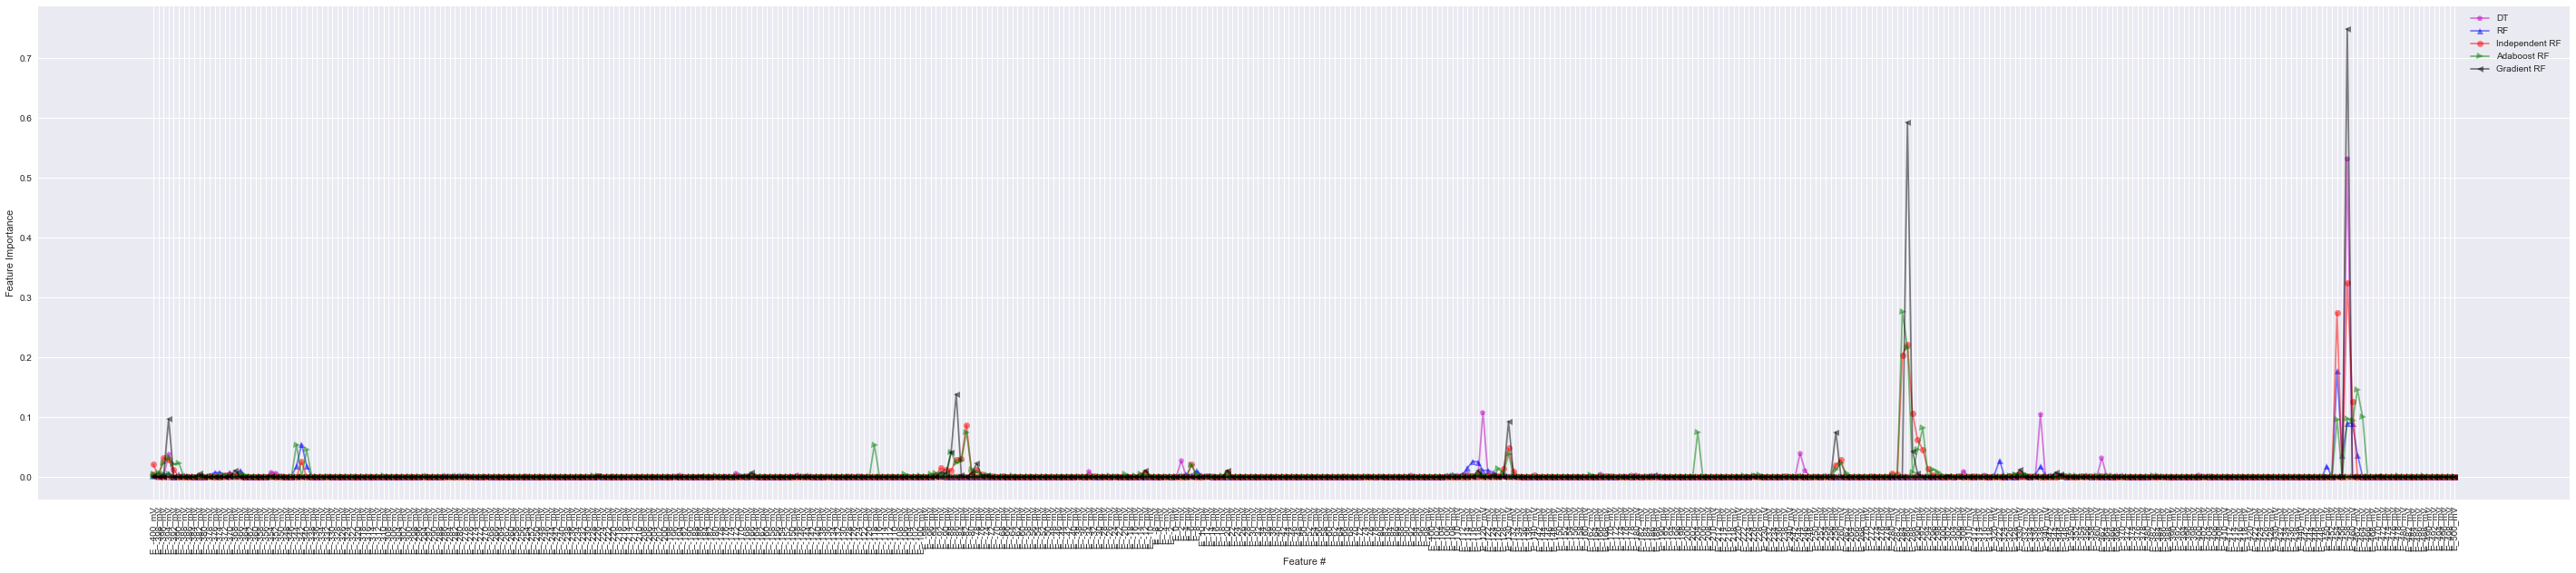

In [41]:
Features = linspace(0,451, 451)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, energy_names, rotation = 'vertical')
xlabel('Feature #')
ylabel('Feature Importance')

(0, 50)

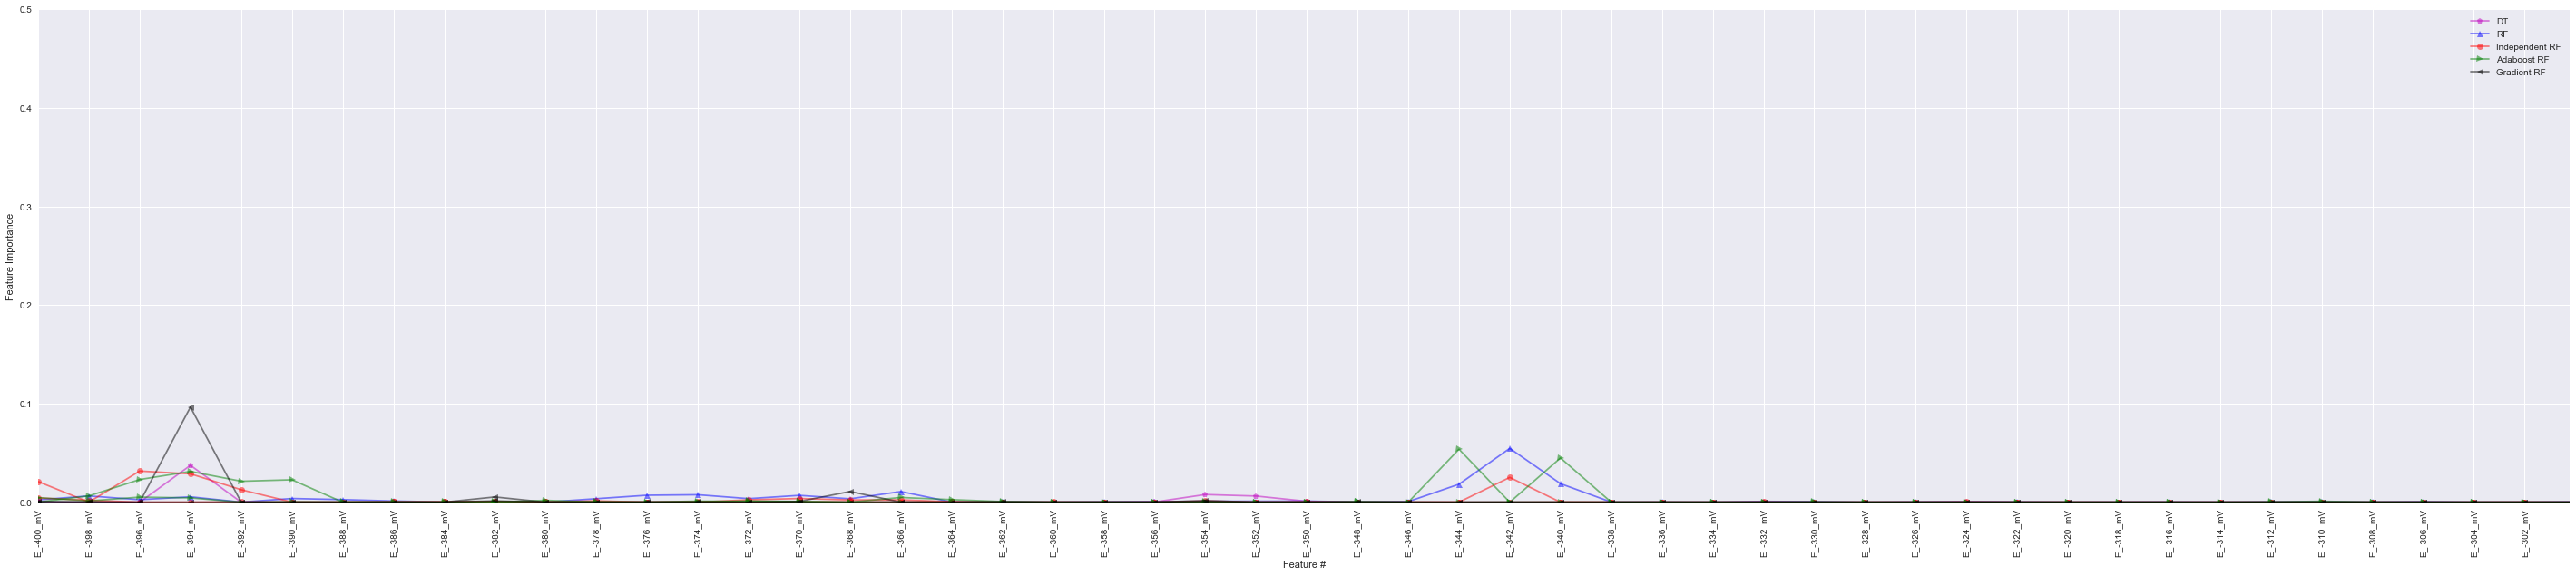

In [42]:
Features = linspace(0,451, 451)
figure(figsize=(50,10))
plt.plot(Features, importance_DT_, 'mp-', alpha = 0.5, label = "DT")
plt.plot(Features, importance_RF_, 'b^-', alpha = 0.5, label = "RF")
plt.plot(Features, importance_IRF_i,  'ro-', alpha = 0.5, label = "Independent RF")
plt.plot(Features, importance_IRF_r,  'ro-', alpha = 0.5)
plt.plot(Features, importance_ARF_i, 'g>-',alpha = 0.5, label = "Adaboost RF")
plt.plot(Features, importance_ARF_r, 'g>-',alpha = 0.5)
plt.plot(Features, importance_GRF_i, 'k<-', alpha = 0.5, label = "Gradient RF")
plt.plot(Features, importance_GRF_r, 'k<-', alpha = 0.5)
legend(loc = 'best')
plt.xticks(Features, energy_names, rotation = 'vertical')
xlabel('Feature #')
ylabel('Feature Importance')
ylim([0, 0.50])
xlim([0, 50])